In [28]:
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation
import scanpy as sc
import os
import scipy.io
import pandas as pd

In [27]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
data_path = "../data/GSM5008737_RNA_3P"
filtered_path = "../data/filtered_GSM5008737_RNA_3P"

In [16]:
adata = sc.read_10x_mtx(
    data_path,
    var_names="gene_ids",
    make_unique=True
)


In [17]:
adata.var_names_make_unique()

In [18]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [19]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 161764 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_symbols', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

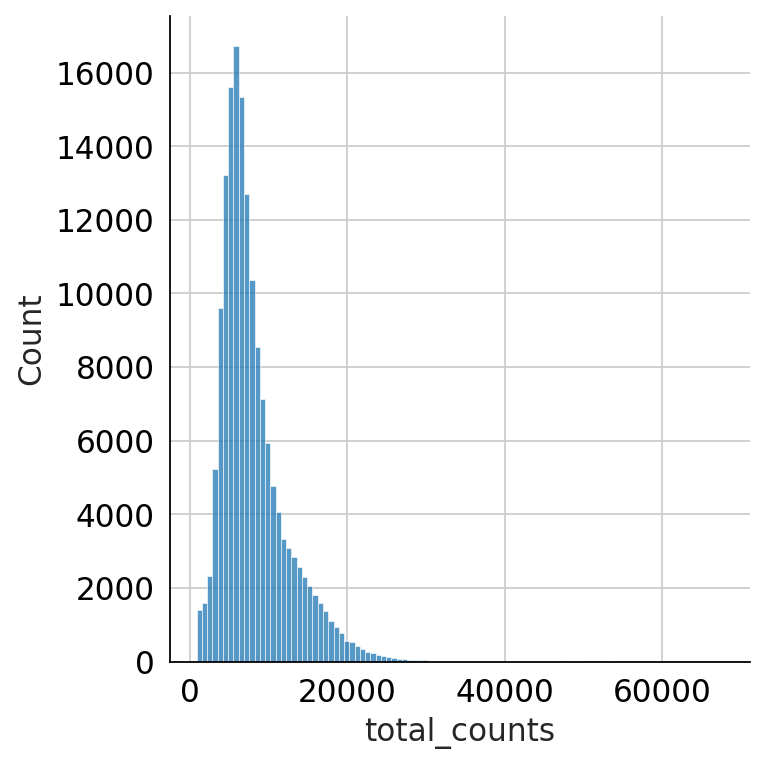

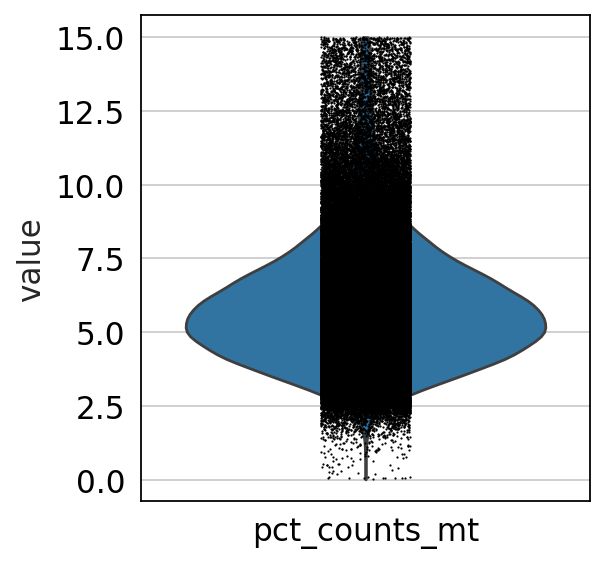

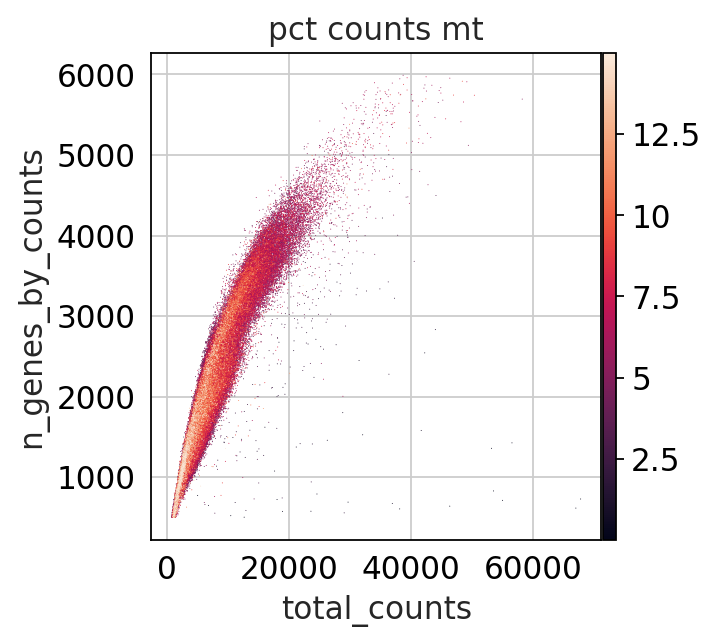

In [20]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [21]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [22]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    159051
True       2713
Name: count, dtype: int64

In [23]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    138308
True      23456
Name: count, dtype: int64

In [24]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 161764
Number of cells after filtering of low quality cells: 137072


In [25]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 137072
Number of cells after filtering of low quality cells: 137072


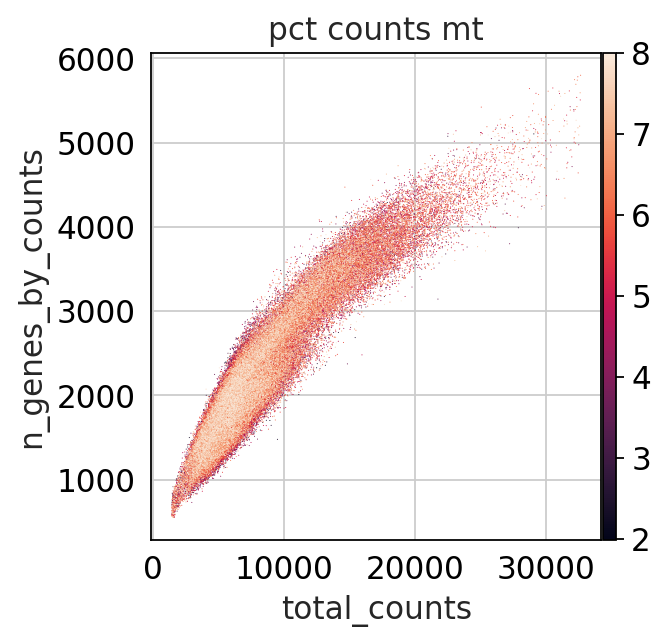

In [26]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [29]:
os.makedirs(filtered_path, exist_ok=True)

# Matrix exportieren: SoupX erwartet Gene x Zellen
scipy.io.mmwrite(f"{filtered_path}/matrix.mtx", adata.X.T)

# Features/Gene exportieren
pd.DataFrame(adata.var_names).to_csv(
    f"{filtered_path}/features.tsv",
    sep="\t", header=False, index=False
)

# Barcodes/Zellen exportieren
pd.DataFrame(adata.obs_names).to_csv(
    f"{filtered_path}/barcodes.tsv",
    sep="\t", header=False, index=False
)

print("Filtered matrix exported for SoupX:", filtered_path)

Filtered matrix exported for SoupX: ../data/filtered_GSM5008737_RNA_3P


Error in library(SoupX) : there is no package called ‘SoupX’
Execution halted


CalledProcessError: Command '['Rscript', 'soupX_workflow.R', 'raw_feature_bc_matrix', 'soup_input_filtered', 'soupX_corrected']' returned non-zero exit status 1.